# Melanoma images - Hair Augmentation

## Setup

In [37]:
import pandas as pd

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

import PIL

from tempfile import TemporaryFile
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import albumentations as albu
import tensorflow as tf

In [38]:
import cv2
import os
import argparse

In [39]:
train_path = '/home/leslie/code/melanoma_files/jpeg/train/'
test_path = '/home/leslie/code/melanoma_files/jpeg/test/'

In [40]:
BASE_PATH = '/home/leslie/code/melanoma_files/jpeg/train/'
#list of images with hair
hair_images =['ISIC_0078712','ISIC_0080817','ISIC_0082348','ISIC_0109869',
              'ISIC_0155012','ISIC_0159568','ISIC_0164145','ISIC_0194550',
              'ISIC_0194914','ISIC_0202023','ISIC_0083035','ISIC_0068279',
              'ISIC_0109703','ISIC_0149527', 'ISIC_0094701', 'ISIC_0171235', 
              'ISIC_0221351','ISIC_0292158']

## View images

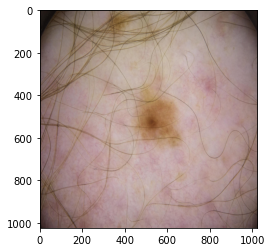

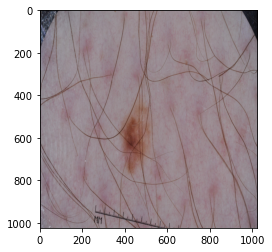

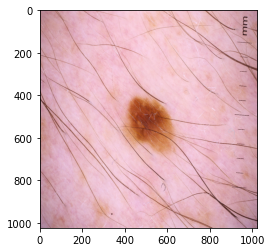

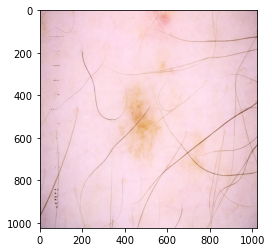

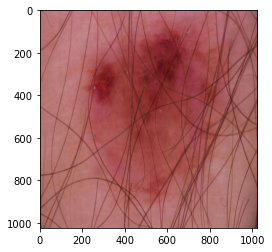

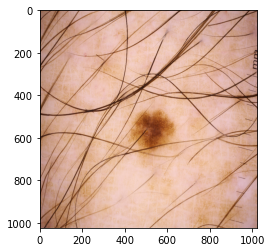

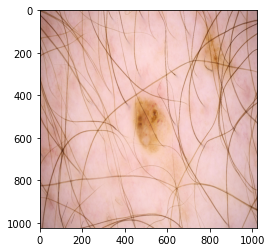

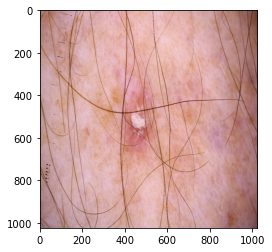

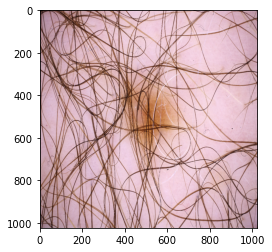

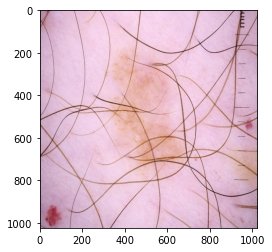

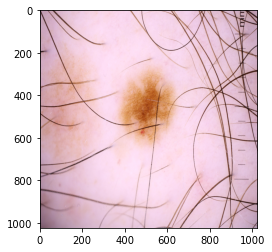

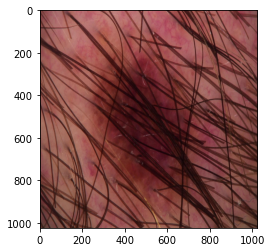

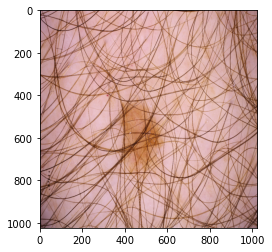

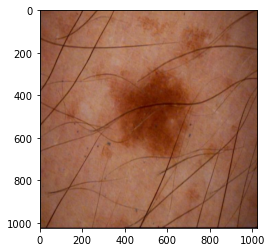

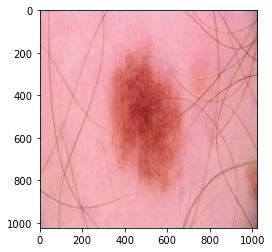

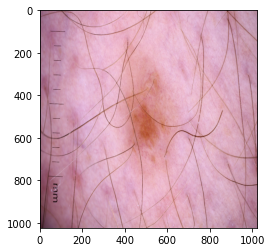

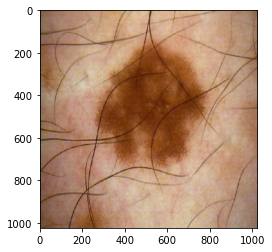

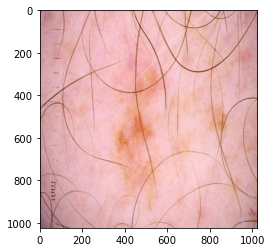

In [41]:
size = 1024
for img in hair_images:
    image = cv2.imread(BASE_PATH + img + '.jpg')
    image_resize = cv2.resize(image,(size,size))
    image_resize = cv2.cvtColor(image_resize,cv2.COLOR_BGR2RGB)
    plt.imshow(image_resize)
    plt.show()

## Extract hair mask

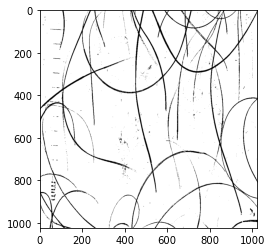

In [42]:
lower_limit = 20 # the value that I found helpful

#*********#*********PROCEDURE*********#*********#*********#
###################################
grayScale = cv2.cvtColor(image_resize, cv2.COLOR_RGB2GRAY)

# Kernel for the morphological filtering
kernel = cv2.getStructuringElement(1,(17,17))

# Perform the blackHat filtering on the grayscale image to find the hair countours
blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

# intensify the hair countours  
_ ,threshold = cv2.threshold(blackhat,20,255,cv2.THRESH_BINARY)
#######################################
threshold = cv2.bitwise_not(threshold)
plt.imshow(threshold,cmap = 'gray')

In [43]:
def img(image_name,lower_limit=20):    
 
    image = cv2.imread(BASE_PATH + image_name + '.jpg')
    image_resize = cv2.resize(image,(size,size))
   
    grayScale = cv2.cvtColor(image_resize, cv2.COLOR_RGB2GRAY)

    # Kernel for the morphological filtering
    kernel = cv2.getStructuringElement(1,(17,17))

    # Perform the blackHat filtering on the grayscale image to find the hair countours
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

    # intensify the hair countours in preparation for the inpainting 
    _ ,threshold = cv2.threshold(blackhat,lower_limit,255,cv2.THRESH_BINARY)
    
    # inpaint the original image depending on the mask
    final_image = cv2.inpaint(image_resize,threshold,1,cv2.INPAINT_TELEA)
    
    threshold = cv2.bitwise_not(threshold)
    image_resize = cv2.cvtColor(image_resize,cv2.COLOR_BGR2RGB)
    final_image = cv2.cvtColor(final_image,cv2.COLOR_BGR2RGB)
    
    return image_resize,threshold,final_image

## Get first image

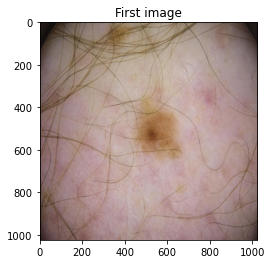

In [44]:
image_1,_,_ = img(hair_images[0]) 

plt.title('First image')
plt.imshow(image_1)
plt.show()

## Get second image and hair mask

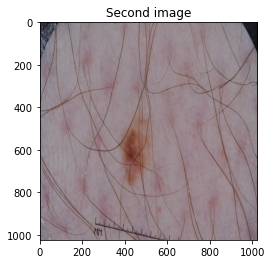

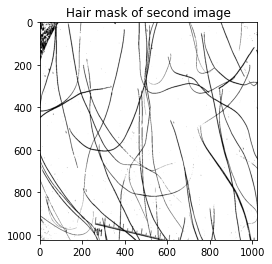

In [45]:
image_2,hair_mask_2,_ = img(hair_images[1])

plt.title('Second image')
plt.imshow(image_2)
plt.show()

plt.title('Hair mask of second image')
plt.imshow(hair_mask_2,cmap = 'binary_r')
plt.show()

## Apply hair mask of image 2 on image 1

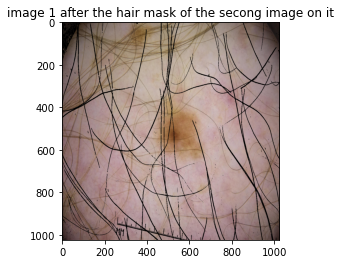

In [46]:
plt.title('image 1 after the hair mask of the secong image on it')
plt.imshow(cv2.bitwise_and(image_1,image_1,mask = hair_mask_2))


## Find best hair masks for later use

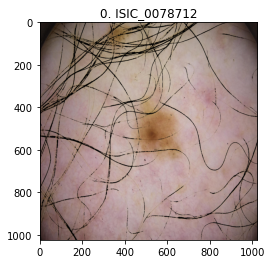

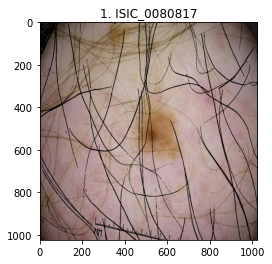

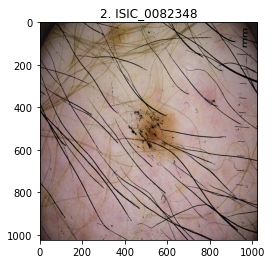

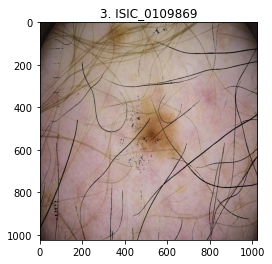

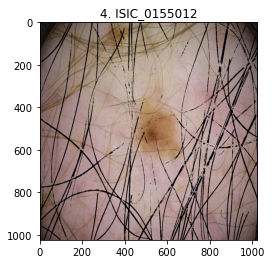

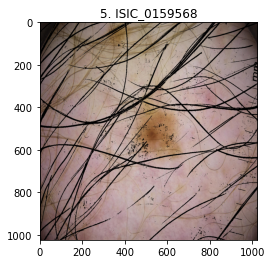

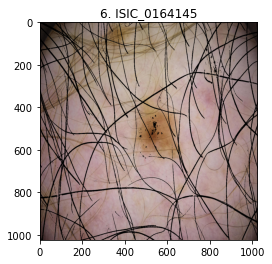

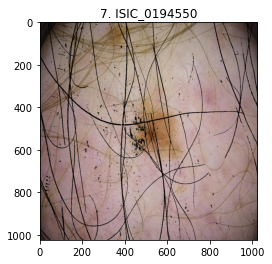

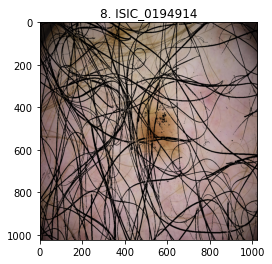

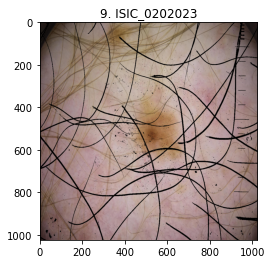

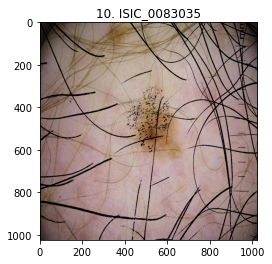

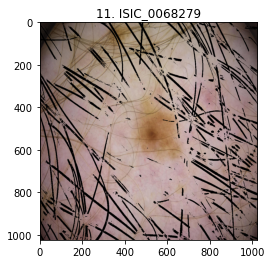

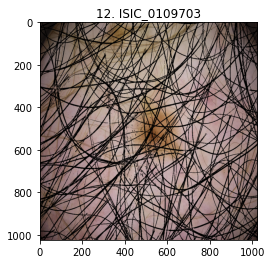

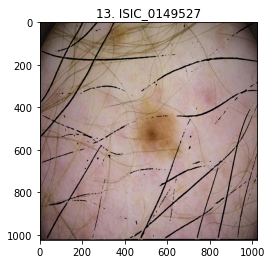

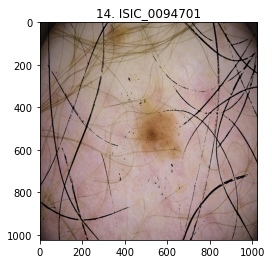

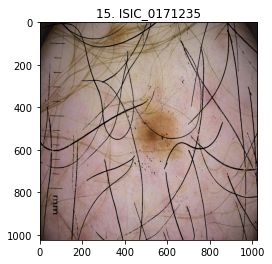

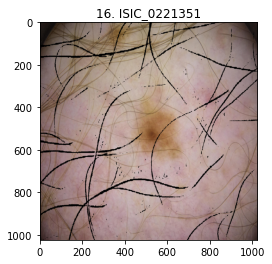

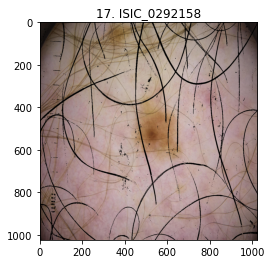

In [47]:
for i,img_name in enumerate(hair_images) :
    _,hair_mask,_ = img(img_name)
    plt.title(f'{i}. {img_name}')
    plt.imshow(cv2.bitwise_and(image_1,image_1,mask = hair_mask))
    plt.show()

## Select possible hair masks for later use

In [48]:
possible_masks = [3,4,6,9,13,14,16]# possibly exclude 6, 9

all_hair_masks = []

for i,img_id in enumerate(possible_masks):
    _,hair_masks,_ = img(hair_images[img_id])
    all_hair_masks.append(hair_masks) 
    cv2.imwrite(f'image_{i}.jpg',hair_masks)

## Save masks as array

In [49]:
np.save('hair_array.npy', np.array(all_hair_masks, dtype = np.uint8))

## Implementation

In [50]:
#loading the hairs
hairs = np.load('hair_array.npy')

#the random transformations we want to apply on the masks
hair_trans = albu.Compose([
    albu.ShiftScaleRotate(rotate_limit=[-45,45],scale_limit=[-0.1,0.1],
                          shift_limit=[-0.1,0.15],border_mode=3,value=0,p=1.)])

In [51]:
#our augmenter
from numpy.random import choice
def hair_mask(hairs,IMAGE_SIZE,p = 0.3):
    chance = np.random.uniform(0,1,1)
    if chance <= p:
        mask_to_chose = choice(np.arange(7), 1,p=[0.2,0.2,0.22,0.15,0.14,0.06,0.03])[0]
        mask = hairs[mask_to_chose]
        
        mask = hair_trans(image = mask)['image']
        mask = cv2.resize(mask/255,(IMAGE_SIZE,IMAGE_SIZE),cv2.INTER_CUBIC)
        mask[mask == 1.] =  255
        mask[mask != 255.] = 0
        
        
    else:
        mask = np.ones((IMAGE_SIZE,IMAGE_SIZE))
    return mask

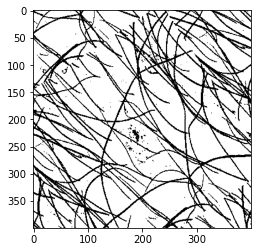

In [52]:
# Show random hair mask

msk = hair_mask(hairs,IMAGE_SIZE=400,p=1.).astype(np.uint8)
plt.imshow(msk,cmap = 'binary_r')

In [53]:
img = cv2.imread(train_path + 'ISIC_0015719.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(400,400))

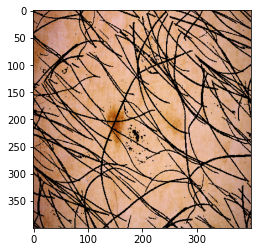

In [54]:
plt.imshow(cv2.bitwise_and(img,img,mask= msk))

# Save altered images

In [55]:
original_path = "/home/leslie/code/melanoma_files_small/jpeg/"
save_aug_path = "/home/leslie/code/melanoma_files_small/aug/"
categories = ['train', 'test']
margin = 0
kernel_size = 31
percentage_of_area = 0

# go into "train" or "test" folder
for category in categories:
    path = os.path.join(original_path, category)
    save_path = os.path.join(save_aug_path, category)
    
    # loop over images in the folder
    for saved_img in os.listdir(path):
        
        image_file = os.path.join(path,saved_img)

        orig_img = cv2.imread(image_file) #0
        
        
        msk = hair_mask(hairs,IMAGE_SIZE=400,p=1.).astype(np.uint8)
        
        img = cv2.imread(image_file)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(400,400))
                        
        cv2.imwrite(os.path.join(save_path + "/" + saved_img), cv2.bitwise_and(img,img,mask= msk))
        cv2.waitKey(0)
        

In [ ]:
# class DataGenerator(tf.keras.utils.Sequence):
# #     'Generates data for Keras'
#     def __init__(self, filelist_x, targets, batch_size=128, shuffle=False, augment=False, labels=True): 

#         self.filelist_x = filelist_x
#         self.targets = targets
#         self.augment = augment
#         self.shuffle = shuffle
#         self.batch_size = batch_size
#         self.labels = labels
#         self.on_epoch_end()
        
#     def __len__(self):
# #         'Denotes the number of batches per epoch'
#         ct = len(self.filelist_x) // self.batch_size
#         ct += int((len(self.filelist_x) % self.batch_size)!=0)
#         return ct

#     def __getitem__(self,index):
# #         'Generate one batch of data'
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
#         X, y = self.__data_generation(indexes)
#         if self.augment: X = self.__augment_batch(X)
#         if self.labels: return X, y
#         else: return X

#     def on_epoch_end(self):
# #         'Updates indexes after each epoch'
#         self.indexes = np.arange( len(self.filelist_x) )
#         if self.shuffle: np.random.shuffle(self.indexes)

#     def __data_generation(self,indexes):
# #         'Generates data containing batch_size samples'   

#         X = np.array([lycon.load(self.filelist_x[indexes][i]) for i in range(len(indexes))])
#         y = self.targets[indexes]
        
#         return X, y
 
#     def __random_transform(self, img):
#         composition = albu.Compose([
#             albu.OneOf([
#                 albu.ShiftScaleRotate(rotate_limit=[-90,90],scale_limit=[-0.42,0.35],shift_limit=0,border_mode=0,value=0,p=0.5),
#                 albu.CoarseDropout(max_holes=16,max_height=200//10,max_width=200//10,fill_value=0,p=0.5)
#             ], p=0.5),
#             albu.ShiftScaleRotate(rotate_limit=0, scale_limit=0., shift_limit=0.15, border_mode=0, value=0, p=0.5)
#         ])
#         image = composition(image=img)['image']
#         ##############################################################}
#         mask =  hair_mask(hairs,IMAGE_SIZE,p = 0.3).astype(np.uint8)##} This area!!
#         image = cv2.bitwise_and(image,image,mask = mask)##############}
#         ##############################################################}
#         return image
    
#     def __augment_batch(self, img_batch):
#         for i in range(img_batch.shape[0]):
#             img_batch[i, ] = self.__random_transform(img_batch[i, ])
#         return img_batch